In [30]:
import pandas as pd
import numpy as np

# Depuración de steam_games
- Nos concentramos únicamente en los campos que necesitamos para luego poder realizar las Funciones. lista_columnas = ['genres', 'release_date', 'price', 'item_id', 'developer']
- No vamos a eliminar los datos que estén nulos en cada columna si hay datos en las demás.
- Se crea un archivo "depurado" y un archivo "depurado y reducido" para ser consumido por la API.
- Podría intentar realizar un scraping de la información necesaria para las funciones (Scraping.ipynb). Sólo si llego.

In [31]:
# Levanto los datos
df_steam_games = pd.read_parquet('..\\datasets\\1. Extracción\\steam_games.parquet')

- Análisis de la columna 'price'. Como "price" contenía texto y números al momento de la carga de datos, fue necesario guardarlo como "string" en el archivo parquet.
- Ahora analizamos cuáles son los valores que "no son precios".

In [32]:
# Convertir 'price' en texto para asegurarnos que se puede manipular correctamente
df_steam_games['price'] = df_steam_games['price'].astype(str)

# Filtrar valores que no pueden ser convertidos a float (es decir, son texto) y cuento
df_steam_games[~df_steam_games['price'].str.replace('.', '', 1).str.isnumeric()]['price'].value_counts()

price
nan                              89687
Free                               905
Free to Play                       520
Free To Play                       462
Free Mod                             4
Free Demo                            3
Play for Free!                       2
Third-party                          2
Play Now                             2
Starting at $499.00                  1
Free Movie                           1
Free to Try                          1
Starting at $449.00                  1
Install Theme                        1
Play the Demo                        1
Free HITMAN™ Holiday Pack            1
Play WARMACHINE: Tactics Demo        1
Install Now                          1
Free to Use                          1
Name: count, dtype: int64

- Como resultado se observa:
    - "nan": son valores nulos, los trataremos como nulos al momento de transformar "price" en valor numérico nuevamente.
    - La gran mayoría contienen la palabra "Free". Tomaremos a todos los que no son "nan" y no son número como Free. Le ponemos valor "0" USD y creamos una columna "Free" = True or "False" que puede ser necesaria para un mejor funcionamiento de la API.

In [33]:
# Reemplazo valores específicos
df_steam_games['price'] = df_steam_games['price'].replace('Starting at $499.00', '499')
df_steam_games['price'] = df_steam_games['price'].replace('Starting at $449.00', '449')

# Reemplazar los valores textuales por 0, excepto los "nan"
df_steam_games['price'] = df_steam_games['price'].apply( lambda x: 0 if (x != 'nan' and not x.replace('.', '', 1).isnumeric()) else x)

# Convertir a tipo float y los "nan" a "NaN"
df_steam_games['price'] = pd.to_numeric(df_steam_games['price'], errors='coerce')

# Crear la columna 'Free', donde si el precio es 0 la columna es "True"
df_steam_games['free'] = df_steam_games['price'].apply(lambda x: True if x == 0 else False)

#Verifico la cantidad de "Free"
cantidad_free = df_steam_games['free'].sum()
print(cantidad_free)

1908


- Realizo algunas modificaciones más:
    - Reemplazamoslos valores "Non" por nulos de numpy
    - Descartamos todas las filas que tengan todos los campos Nulos.
    - Modificamos el formato del campo fecha como DateTime.
    - Creamos una columna con el año que se va a requerir en la API.
    - Renombramos el campo id para que coincida con la tabla de users_items, la modificamos a número y eliminamos todas las filas que tengan un nulo en el id.    

In [34]:
# Reemplazar None y np.nan por np.nan (en caso de que haya strings 'nan')
df_steam_games = df_steam_games.replace({None: np.nan})

# Eliminar filas donde TODOS los valores son nulos
df_steam_games = df_steam_games.dropna(how='all')

# Modifico el formato de 'release_date' 
df_steam_games['release_date'] = pd.to_datetime(df_steam_games['release_date'], errors='coerce')

# Creo la columna con el año de 'release_date' que se necesita en "developer"
df_steam_games['year'] = df_steam_games['release_date'].dt.year

# Renombramos id a item_id
df_steam_games = df_steam_games.rename(columns={'id': 'item_id'})

# item_id tiene que ser un número -- Lo había pasado a número pero después no me servía para hacer el link en las fucniones
# df_steam_games['item_id'] = pd.to_numeric(df_steam_games['item_id'], errors='coerce')

# Eliminar filas donde item_id es nulo
df_steam_games = df_steam_games.dropna(subset=['item_id'])

- Análisis de duplicados

In [35]:
# Contar la cantidad de líneas duplicadas - Considero las columnas que voy a utilziar en la API menos la de "genres" que tiene un Array dentro.
duplicated_count = df_steam_games.duplicated(subset = ['release_date', 'price', 'item_id', 'developer','year','free']).sum()
print(duplicated_count )

1


In [36]:
# Filtrar las líneas duplicadas
duplicated_rows = df_steam_games[df_steam_games.duplicated(subset=['release_date', 'price', 'item_id', 'developer', 'year', 'free'], keep=False)]
duplicated_rows.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year
102204,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,False,2017.0
102883,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,False,2017.0


In [37]:
# Elimino duplicados en base al subconjunto de columnas
df_steam_games_cleaned = df_steam_games.drop_duplicates(subset=['release_date', 'price', 'item_id', 'developer', 'year', 'free'], keep='first')

In [38]:
# Verificar el resultado
print(df_steam_games.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32133 entries, 88310 to 120444
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     24082 non-null  object        
 1   genres        28851 non-null  object        
 2   app_name      32132 non-null  object        
 3   title         30084 non-null  object        
 4   url           32133 non-null  object        
 5   release_date  29782 non-null  datetime64[ns]
 6   tags          31971 non-null  object        
 7   reviews_url   32133 non-null  object        
 8   specs         31464 non-null  object        
 9   price         30756 non-null  float64       
 10  early_access  32133 non-null  object        
 11  item_id       32133 non-null  object        
 12  developer     28835 non-null  object        
 13  free          32133 non-null  bool          
 14  year          29782 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float

Analizo outliers de price y de release_date.

In [39]:
print(df_steam_games.describe())

                        release_date         price          year
count                          29782  30756.000000  29782.000000
mean   2015-04-21 10:49:09.916056832      8.896955   2014.759251
min              1970-07-15 00:00:00      0.000000   1970.000000
25%              2014-10-01 00:00:00      2.990000   2014.000000
50%              2016-04-18 00:00:00      4.990000   2016.000000
75%              2017-04-17 00:00:00      9.990000   2017.000000
max              2021-12-31 00:00:00    995.000000   2021.000000
std                              NaN     16.341118      3.508234


- "release_date" tiene fechas razonables. Tenía dudas sobre la fecha más vieja, 15/07/1970, pero se verifica en la web.

<img src="./_src/Juego_Más_Viejo.PNG" height="300"><br>

In [40]:
df_steam_games['release_date'].min()

Timestamp('1970-07-15 00:00:00')

In [41]:
df_steam_games[df_steam_games['release_date'] == df_steam_games['release_date'].min()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year
103157,NaN,NaN,Last Train To Berlin,Last Train To Berlin,http://store.steampowered.com/app/734030/Last_...,1970-07-15,[Movie],http://steamcommunity.com/app/734030/reviews/?...,[Captions available],3.99,False,734030,NaN,False,1970.0


In [42]:
df_steam_games['release_date'].max()

Timestamp('2021-12-31 00:00:00')

- "price": si bien la media es baja, los valores extremos no parecieran estar errados, es razonable que un juego pueda valer 995 USD.

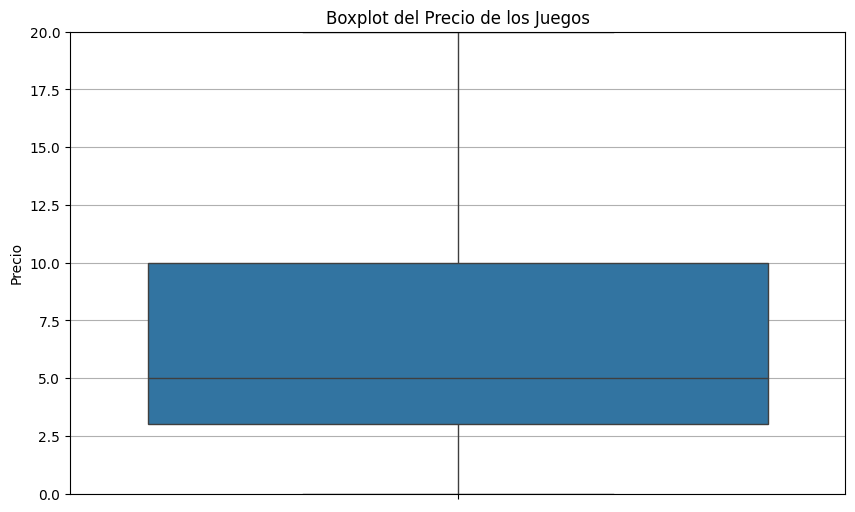

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un boxplot para la columna 'price' usando seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_steam_games['price'])
plt.title('Boxplot del Precio de los Juegos')
plt.ylabel('Precio')
plt.grid(axis='y')  # Agregar líneas de cuadrícula en el eje y
plt.ylim(0,20)
plt.show()


In [44]:
# Guardo el DF depurado con todas las columnas.
df_steam_games.to_parquet('..\\datasets\\2. Depurado\\steam_games_depurado.parquet', index=False)

# Me quedo con las columnas que voy a usar en la API: genres, released_date, price, item_id  y developer
lista_columnas = ['genres', 'release_date', 'price', 'item_id', 'developer','year','free']
df_steam_games = df_steam_games[lista_columnas]

# Guardo el DF para levantarlo con la API.
df_steam_games.to_parquet('..\\datasets\\3. Depurado y Reducido\\steam_games_dep_reducido.parquet', index=False)

---
# Depuración de users_reviews

In [45]:
# #Levanto los datos
df_reviews = pd.read_parquet('..\\datasets\\1. Extracción\\user_reviews.parquet')

In [46]:
df_reviews.head()

,user_id,user_url,item_id,posted,helpful,recommend,funny,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,"Posted November 5, 2011.",No ratings yet,True,,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,"Posted July 15, 2011.",No ratings yet,True,,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,"Posted April 21, 2011.",No ratings yet,True,,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,251610,"Posted June 24, 2014.",15 of 20 people (75%) found this review helpful,True,,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,227300,"Posted September 8, 2013.",0 of 1 people (0%) found this review helpful,True,,For a simple (it's actually not all that simpl...


- Análisis de duplicados

In [47]:
# Filtrar filas donde user_id o item_id son nulos
filtered_reviews = df_reviews[df_reviews['user_id'].isnull() | df_reviews['item_id'].isnull()]

# Contar la cantidad de líneas duplicadas en el DataFrame filtrado
duplicated_count = filtered_reviews.duplicated().sum()

# Mostrar la cantidad de líneas duplicadas
print(f'Cantidad de líneas duplicadas (con user_id o item_id nulos): {duplicated_count}')


Cantidad de líneas duplicadas (con user_id o item_id nulos): 0


In [48]:
# Contar la cantidad de líneas duplicadas
duplicated_count = df_reviews.duplicated().sum()
print(f'Cantidad de líneas duplicadas: {duplicated_count}')

# Contar la cantidad de ocurrencias de cada combinación user_id - item_id
repeated_relationships = df_reviews.groupby(['user_id', 'item_id']).size().reset_index(name='count')

# Filtrar las relaciones que se repiten (más de una vez)
repeated_relationships = repeated_relationships[repeated_relationships['count'] > 1]

# Sumar las ocurrencias de las combinaciones repetidas
total_repeated_count = repeated_relationships['count'].sum()

# Calcular la diferencia
difference = duplicated_count - total_repeated_count

# Mostrar los resultados
print(f'Cantidad de relaciones repetidas: {repeated_relationships.shape[0]}')
print(f'Cantidad total de duplicados en las combinaciones: {total_repeated_count}')
print(f'Diferencia entre duplicados totales y duplicados de relaciones: {difference}')

Cantidad de líneas duplicadas: 874
Cantidad de relaciones repetidas: 862
Cantidad total de duplicados en las combinaciones: 1736
Diferencia entre duplicados totales y duplicados de relaciones: -862


In [49]:
# Verifico con un ejemplo
filtered_reviews = df_reviews[(df_reviews["user_id"] == "05041129") & (df_reviews["item_id"] == "277430")]

# Mostrar el DataFrame filtrado
filtered_reviews.head()

,user_id,user_url,item_id,posted,helpful,recommend,funny,review
13415,05041129,http://steamcommunity.com/id/05041129,277430,"Posted January 5, 2015.",1 of 1 people (100%) found this review helpful,True,1 person found this review funny,this is the best third person game ever that i...
32000,05041129,http://steamcommunity.com/id/05041129,277430,"Posted January 5, 2015.",1 of 1 people (100%) found this review helpful,True,1 person found this review funny,this is the best third person game ever that i...


- Elimino las filas duplicadas

In [50]:
df_reviews.drop_duplicates(inplace=True)

In [51]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 58459 entries, 0 to 59332
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58459 non-null  object
 1   user_url   58459 non-null  object
 2   item_id    58431 non-null  object
 3   posted     58431 non-null  object
 4   helpful    58431 non-null  object
 5   recommend  58431 non-null  object
 6   funny      58431 non-null  object
 7   review     58431 non-null  object
dtypes: object(8)
memory usage: 4.0+ MB
None


- Verifico las filas que tiene item_id nulo

In [52]:
df_reviews[df_reviews['item_id'].isnull()]

,user_id,user_url,item_id,posted,helpful,recommend,funny,review
137,gdxsd,http://steamcommunity.com/id/gdxsd,None,None,None,None,None,None
177,76561198094224872,http://steamcommunity.com/profiles/76561198094...,None,None,None,None,None,None
2559,76561198021575394,http://steamcommunity.com/profiles/76561198021...,None,None,None,None,None,None
10080,cmuir37,http://steamcommunity.com/id/cmuir37,None,None,None,None,None,None
13767,Jaysteeny,http://steamcommunity.com/id/Jaysteeny,None,None,None,None,None,None
15493,ML8989,http://steamcommunity.com/id/ML8989,None,None,None,None,None,None
19184,76561198079215291,http://steamcommunity.com/profiles/76561198079...,None,None,None,None,None,None
20223,76561198079342142,http://steamcommunity.com/profiles/76561198079...,None,None,None,None,None,None
25056,76561198061996985,http://steamcommunity.com/profiles/76561198061...,None,None,None,None,None,None
26257,76561198108286351,http://steamcommunity.com/profiles/76561198108...,None,None,None,None,None,None


In [53]:
# Elimino las que tienen item_id nulo
df_reviews.dropna(subset=['item_id'],inplace=True)

In [54]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 58431 entries, 0 to 59332
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58431 non-null  object
 1   user_url   58431 non-null  object
 2   item_id    58431 non-null  object
 3   posted     58431 non-null  object
 4   helpful    58431 non-null  object
 5   recommend  58431 non-null  object
 6   funny      58431 non-null  object
 7   review     58431 non-null  object
dtypes: object(8)
memory usage: 4.0+ MB
None


In [55]:
# Guardo el DF depurado.
df_reviews.to_parquet('..\\datasets\\2. Depurado\\user_reviews_depurado.parquet', index=False)

---
# Depuración de users_items

In [56]:
# #Levanto los datos
df_user_items = pd.read_parquet('..\\datasets\\1. Extracción\\users_items.parquet')

In [57]:
df_user_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   user_url          object 
 2   item_id           object 
 3   item_name         object 
 4   playtime_forever  float64
 5   playtime_2weeks   float64
dtypes: float64(2), object(4)
memory usage: 236.7+ MB


In [58]:
# Cuento las que no nulos
print(df_user_items.notnull().sum())

user_id             5170015
user_url            5170015
item_id             5153209
item_name           5153209
playtime_forever    5153209
playtime_2weeks     5153209
dtype: int64


In [59]:
# Cuento las que tienen nulos
print(df_user_items.isnull().sum())

user_id                 0
user_url                0
item_id             16806
item_name           16806
playtime_forever    16806
playtime_2weeks     16806
dtype: int64


- Elimino las filas que no tienen "item_id".

In [60]:
# Eliminar filas donde item_id es nulo
df_user_items = df_user_items.dropna(subset=['item_id'])

- Cuento los duplicados

In [61]:
# Contar la cantidad de líneas duplicadas
duplicated_count = df_user_items.duplicated().sum()
print(duplicated_count)

59104


In [62]:
# Contar la cantidad de ocurrencias de cada combinación user_id - item_id
repeated_relationships = df_user_items.groupby(['user_id', 'item_id']).size().reset_index(name='count')

# Filtrar las relaciones que se repiten (más de una vez)
repeated_relationships = repeated_relationships[repeated_relationships['count'] > 1]
repeated_relationships

,user_id,item_id,count
6680,05041129,104900,2
6681,05041129,105600,2
6682,05041129,17080,2
6683,05041129,204360,2
6684,05041129,218230,2
...,...,...,...
5084021,zeroblade,9460,2
5084022,zeroblade,9480,2
5084023,zeroblade,96400,2
5084024,zeroblade,97100,2


In [63]:
# Verifico con un ejemplo
filtered_reviews = df_user_items[(df_user_items["user_id"] == "05041129") & (df_user_items["item_id"] == "104900")]

# Mostrar el DataFrame filtrado
filtered_reviews.head()

,user_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
1095504,05041129,http://steamcommunity.com/id/05041129,104900,ORION: Prelude,0.0,0.0
2715806,05041129,http://steamcommunity.com/id/05041129,104900,ORION: Prelude,0.0,0.0


In [64]:
# Elimino las filas dupicads
df_user_items.drop_duplicates(inplace=True)

In [65]:
# Cuento las que no nulos
print(df_user_items.notnull().sum())

user_id             5094105
user_url            5094105
item_id             5094105
item_name           5094105
playtime_forever    5094105
playtime_2weeks     5094105
dtype: int64


In [66]:
print(df_user_items.describe())

       playtime_forever  playtime_2weeks
count      5.094105e+06     5.094105e+06
mean       9.905511e+02     9.069004e+00
std        5.414297e+03     1.403145e+02
min        0.000000e+00     0.000000e+00
25%        0.000000e+00     0.000000e+00
50%        3.400000e+01     0.000000e+00
75%        3.550000e+02     0.000000e+00
max        6.427730e+05     1.996700e+04


In [67]:
# item_idid tiene que ser un número
# df_user_items['item_id'] = pd.to_numeric(df_user_items['item_id'], errors='coerce')

In [68]:
# Guardo el DF en parquet para levantarlo más rápido la próxima vez.
df_user_items.to_parquet('..\\datasets\\2. Depurado\\users_items_depurado.parquet', index=False)